# 银行用户流失分析
数据源: https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers <br>
案例参考：https://www.kaggle.com/code/thomaskonstantin/bank-churn-data-exploration-and-churn-prediction/notebook <br>
作者：张哲宁、夏伯平 <br>

故事背景：[*待补充*]<br>
我们希望通过分析银行信用卡客户的流失数据，推导出哪些客户的流失率更高，从而对这些客户进行针对性的服务，以此来减少信用卡客户的流失率



**目录**
1. 数据导入
2. 数据预处理
3. 数据图像分析
4. 决策树模型判断用户流失条件
5. 生成流失群体分析报告

## 1. 数据导入
包含数据源导入和两个数据表格的合并

In [95]:
# import packages 关键
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# ignore warnings 可以删除
import warnings
warnings.filterwarnings("ignore")
# 为了让matplotlib里显示中文字符
import matplotlib.font_manager as fm 
matplotlib.rcParams['font.family'] = 'Microsoft Yahei'

In [96]:
# 导入数据
data_customer = pd.read_excel('用户个人信息.xlsx') 
data_credit_card = pd.read_csv('用户银行卡信息.csv') 

In [97]:
# 数据表合并
data = pd.merge(data_customer, data_credit_card, on='ID', how='inner')
data.head() # 查看前5行

,ID,年龄,性别,家庭成员,受教育程度,婚姻状态,收入,是否流失,信用卡类别,开卡的总月份,不活跃月份个数（一年）,银行服务次数（一年）,信用额度,循环信贷,平均每月剩余额度,信用卡总开销,信用卡使用次数,平均利用率
0,768805383,45.0,男,3,高中,已婚,6-8万,否,普通卡,39,1,3,12691.0,777,11914.0,1144,42,0.061
1,818770008,49.0,女,5,研究生,单身,小于4万,否,普通卡,44,1,2,8256.0,864,7392.0,1291,33,0.105
2,713982108,51.0,男,3,研究生,已婚,8-12万,否,普通卡,36,1,0,3418.0,0,3418.0,1887,20,0.000
3,769911858,40.0,女,4,高中,NaN,小于4万,否,普通卡,34,4,1,3313.0,2517,796.0,1171,20,0.760
4,709106358,40.0,男,3,未受教育,已婚,6-8万,否,普通卡,21,1,0,4716.0,0,4716.0,816,28,0.000


In [98]:
# 合并数据展示
print("合并后的数据有{}行，{}列".format(data.shape[0], data.shape[1]))

合并后的数据有10457行，18列


In [99]:
# 使用info()函数对数据表进行初步预览
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10457 entries, 0 to 10456
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           10457 non-null  int64  
 1   年龄           10321 non-null  float64
 2   性别           10457 non-null  object 
 3   家庭成员         10457 non-null  int64  
 4   受教育程度        8890 non-null   object 
 5   婚姻状态         9693 non-null   object 
 6   收入           9321 non-null   object 
 7   是否流失         10457 non-null  object 
 8   信用卡类别        10457 non-null  object 
 9   开卡的总月份       10457 non-null  int64  
 10  不活跃月份个数（一年）  10457 non-null  int64  
 11  银行服务次数（一年）   10457 non-null  int64  
 12  信用额度         10457 non-null  float64
 13  循环信贷         10457 non-null  int64  
 14  平均每月剩余额度     10457 non-null  float64
 15  信用卡总开销       10457 non-null  int64  
 16  信用卡使用次数      10457 non-null  int64  
 17  平均利用率        10457 non-null  float64
dtypes: float64(4), int64(8), object(6)
memory usag

从第二行`Int64Index`可以看出，整个数据表有10457条记录。在数据表信息预览表格里，`Non-Null Count`一项告诉我们数据集中每一列信息存在多少个未缺失项。`Dtype`一项告诉我们该列信息的数据类型，从而推断出该列信息是连续数据、离散数据、或分类数据。

In [100]:
# 查看数据分布
data.describe()

,ID,年龄,家庭成员,开卡的总月份,不活跃月份个数（一年）,银行服务次数（一年）,信用额度,循环信贷,平均每月剩余额度,信用卡总开销,信用卡使用次数,平均利用率
count,1.045700e+04,10321.000000,10457.000000,10457.000000,10457.000000,10457.000000,10457.000000,10457.000000,10457.000000,10457.000000,10457.000000,10457.000000
mean,7.390804e+08,46.396861,2.345606,35.955628,2.332983,2.439801,8624.290456,1162.581237,7501.465086,4313.786937,63.988716,0.273100
std,3.683520e+07,8.091354,1.297214,7.998215,1.011059,1.106873,9091.872388,813.884156,9067.897807,3381.658812,23.711962,0.274351
min,7.080821e+08,26.000000,0.000000,13.000000,0.000000,0.000000,-999.000000,0.000000,3.000000,510.000000,10.000000,0.000000
25%,7.130105e+08,41.000000,1.000000,31.000000,2.000000,2.000000,2544.000000,397.000000,1361.000000,2053.000000,44.000000,0.024000
50%,7.179125e+08,46.000000,2.000000,36.000000,2.000000,2.000000,4570.000000,1275.000000,3525.000000,3822.000000,66.000000,0.175000
75%,7.731555e+08,52.000000,3.000000,40.000000,3.000000,3.000000,11154.000000,1782.000000,9942.000000,4713.000000,80.000000,0.497000
max,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,18484.000000,139.000000,0.999000


此处25%、50%、75%代表的是下四分位数、中位数、上四分位数，std代表标准差。

## 2. 数据预处理

### 2.1 缺失值检查与处理

In [101]:
# 去重
print("去重前的数据有{}行，{}列".format(data.shape[0], data.shape[1]))
data.drop_duplicates(inplace=True)
print("去重后的数据有{}行，{}列".format(data.shape[0], data.shape[1]))

去重前的数据有10457行，18列
去重后的数据有10127行，18列


In [102]:
# 查看缺失值
(data.isnull().sum() / data.shape[0]) * 100 # 缺失值百分比

ID              0.000000
年龄              1.165202
性别              0.000000
家庭成员            0.000000
受教育程度          14.999506
婚姻状态            7.396070
收入             10.980547
是否流失            0.000000
信用卡类别           0.000000
开卡的总月份          0.000000
不活跃月份个数（一年）     0.000000
银行服务次数（一年）      0.000000
信用额度            0.000000
循环信贷            0.000000
平均每月剩余额度        0.000000
信用卡总开销          0.000000
信用卡使用次数         0.000000
平均利用率           0.000000
dtype: float64

我们发现只有4列有缺失值：`年龄`、`受教育程度`、`婚姻状况`、`收入`。其中最多的缺失值是受教育程度（15%）。

对于连续数据（`年龄`），我们选择用中位数补全。

对于类别数据`受教育程度`、`婚姻状况`, 我们选择用“未知”来补全缺失值。

对于类别数据`收入`，由于没有很好的补全方法，我们选择直接删除整条记录。

In [103]:
# 年龄：用中位数补全缺失值
data['年龄'].fillna(data['年龄'].median(), inplace=True)
# 受教育程度、婚姻状态：用“未知”来补全缺失值
data['受教育程度'].fillna('未知', inplace=True)
data['婚姻状态'].fillna('未知', inplace=True)
# 收入: 直接删除缺失值
data.dropna(subset=['收入'], inplace=True)

In [104]:
# 确认已经移除所有缺失值
data.isnull().sum()  # 确认已经移除所有缺失值

ID             0
年龄             0
性别             0
家庭成员           0
受教育程度          0
婚姻状态           0
收入             0
是否流失           0
信用卡类别          0
开卡的总月份         0
不活跃月份个数（一年）    0
银行服务次数（一年）     0
信用额度           0
循环信贷           0
平均每月剩余额度       0
信用卡总开销         0
信用卡使用次数        0
平均利用率          0
dtype: int64

In [105]:
print("缺失值总数：{}".format(data.isnull().sum().sum()))

缺失值总数：0


In [106]:
# 处理缺失值之后数据展示
print("处理缺失值后的数据有{}行，{}列".format(data.shape[0], data.shape[1]))

处理缺失值后的数据有9015行，18列


### 2.2 数据格式检查与处理
处理`受教育程度`和`信用卡类别`

In [107]:
# 检查 受教育程度 的格式
print(data['受教育程度'].unique()) # 发现本科生和大学是同一类，需要合并
# 检查 信用卡类别 的格式
print(data['信用卡类别'].unique()) # 发现黑金卡和黑金是同一类，需要合并

['高中' '研究生' '未受教育' '未知' '本科生' '博士' '大学']
['普通卡' '金卡' '银卡' '黑金卡' '黑金']


In [108]:
# 合并 受教育程度: 将大学替换成本科生
data['受教育程度'].replace('大学', '本科生', inplace=True)
# 合并 信用卡类别: 将黑金替换成黑金卡
data['信用卡类别'].replace('黑金', '黑金卡', inplace=True)

# 检查替换后的 受教育程度 和 信用卡类别
print(data['受教育程度'].unique()) # 发现本科生和大学是同一类，需要合并
print(data['信用卡类别'].unique()) # 发现白金卡和白金是同一类，需要合并

['高中' '研究生' '未受教育' '未知' '本科生' '博士']
['普通卡' '金卡' '银卡' '黑金卡']


### 2.3 异常值检查与处理
检查 `信用额度` 里的异常值

In [109]:
# 查看信用额度的分布
data['信用额度'].describe() 
# 1.发现不合理的负数，需要修改成0
# 2.发现最大值和最小值差距较大，需要进行标准化，我们采用对数转换生成新的特征 ‘信用额度log’

count     9015.000000
mean      8485.398846
std       9155.249118
min       -999.000000
25%       2490.000000
50%       4307.000000
75%      10776.000000
max      34516.000000
Name: 信用额度, dtype: float64

In [110]:
# 1. 修改所有的负数为1，若修改为0则会导致取对数后值为负无穷
print("信用额度一共有{}个小于0的数值需要删除.".format(sum(data['信用额度'] < 0))) # 查看小于0的数值
data['信用额度'][data['信用额度'] < 0] = 1 # 将小于0的数值替换成1'
# 检查
data['信用额度'].describe() 

信用额度一共有69个小于0的数值需要删除.


count     9015.000000
mean      8493.052757
std       9147.730921
min          1.000000
25%       2490.000000
50%       4307.000000
75%      10776.000000
max      34516.000000
Name: 信用额度, dtype: float64

In [111]:
# 2. 采用对数生成新的特征 ‘信用额度log’
data['信用额度log'] = np.log(data['信用额度'])

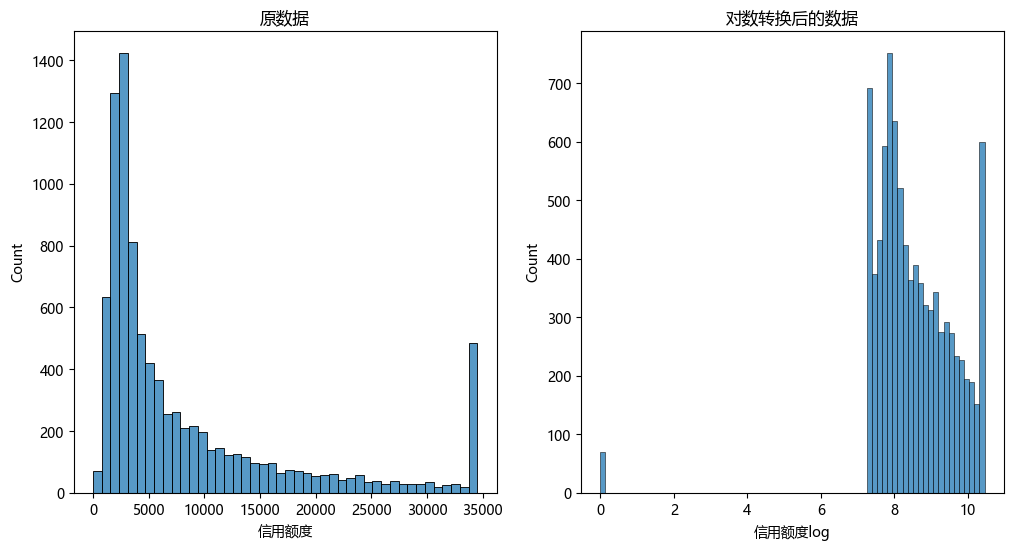

In [112]:
# 用直方图检查信用额度的分布
figure, axis = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(x='信用额度', data=data, ax=axis[0])
axis[0].set_title('原数据')
sns.histplot(x='信用额度log', data=data, ax=axis[1])
axis[1].set_title('对数转换后的数据')
plt.show()

### 2.4 生成新数列
很多时候我们会选择生成新的特征来分析数据，对于这个数据我们希望能了解到每个信用卡用户对信用卡的使用习惯，例如平均他们每次刷卡的额度。我们可以通过用`信用卡总开销`除以`信用卡使用次数`来计算出这个特征：<br>

`平均单次刷卡开销` = `信用卡总开销` / `信用卡使用次数` 

In [113]:
# 生成新数列: 信用卡平均每次开销 = 信用卡总开销 / 信用卡使用次数
data['平均单次刷卡开销'] = data['信用卡总开销'] / data['信用卡使用次数']

In [114]:
# 数据预处理之后数据展示
print("处理缺失值后的数据有{}行，{}列".format(data.shape[0], data.shape[1]))
data.head() # 查看数据预处理之后数据的前5行

处理缺失值后的数据有9015行，20列


,ID,年龄,性别,家庭成员,受教育程度,婚姻状态,收入,是否流失,信用卡类别,开卡的总月份,不活跃月份个数（一年）,银行服务次数（一年）,信用额度,循环信贷,平均每月剩余额度,信用卡总开销,信用卡使用次数,平均利用率,信用额度log,平均单次刷卡开销
0,768805383,45.0,男,3,高中,已婚,6-8万,否,普通卡,39,1,3,12691.0,777,11914.0,1144,42,0.061,9.448648,27.238095
1,818770008,49.0,女,5,研究生,单身,小于4万,否,普通卡,44,1,2,8256.0,864,7392.0,1291,33,0.105,9.018695,39.121212
2,713982108,51.0,男,3,研究生,已婚,8-12万,否,普通卡,36,1,0,3418.0,0,3418.0,1887,20,0.000,8.136811,94.350000
3,769911858,40.0,女,4,高中,未知,小于4万,否,普通卡,34,4,1,3313.0,2517,796.0,1171,20,0.760,8.105609,58.550000
4,709106358,40.0,男,3,未受教育,已婚,6-8万,否,普通卡,21,1,0,4716.0,0,4716.0,816,28,0.000,8.458716,29.142857


## 3. 数据图像分析
1. 单变量分析：年龄，收入，性别，是否流失
2. 双变量分析：年龄&是否流失， 收入&是否流失，不活跃月份个数&是否流失
3. 三变量分析：年龄&性别&是否流失，收入&学历&是否流失，性别&卡类型&是否流失

In [115]:
data.info() # 查看数据预处理之后数据的描述性统计

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9015 entries, 0 to 10456
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           9015 non-null   int64  
 1   年龄           9015 non-null   float64
 2   性别           9015 non-null   object 
 3   家庭成员         9015 non-null   int64  
 4   受教育程度        9015 non-null   object 
 5   婚姻状态         9015 non-null   object 
 6   收入           9015 non-null   object 
 7   是否流失         9015 non-null   object 
 8   信用卡类别        9015 non-null   object 
 9   开卡的总月份       9015 non-null   int64  
 10  不活跃月份个数（一年）  9015 non-null   int64  
 11  银行服务次数（一年）   9015 non-null   int64  
 12  信用额度         9015 non-null   float64
 13  循环信贷         9015 non-null   int64  
 14  平均每月剩余额度     9015 non-null   float64
 15  信用卡总开销       9015 non-null   int64  
 16  信用卡使用次数      9015 non-null   int64  
 17  平均利用率        9015 non-null   float64
 18  信用额度log      9015 non-null   float64
 19  平均单次刷

In [116]:
# 目标特征
target = ['是否流失']
# 类别特征
category_features = [
    '性别', '受教育程度', '婚姻状态', '收入','信用卡类别'
]
# 连续特征
continous_features = [
    '年龄', '家庭成员', '开卡的总月份', '不活跃月份个数（一年）', '银行服务次数（一年）',
    '信用额度', '循环信贷', '平均每月剩余额度', '信用卡总开销', '信用卡使用次数', 
    '平均利用率', '信用额度log', '平均单次刷卡开销'
]

### 3.1 单变量分析
单变量分析主要是帮助我们了解数据中重要特征的分布，我们会分析年龄，性别，是否流失这三个重要数据的分布

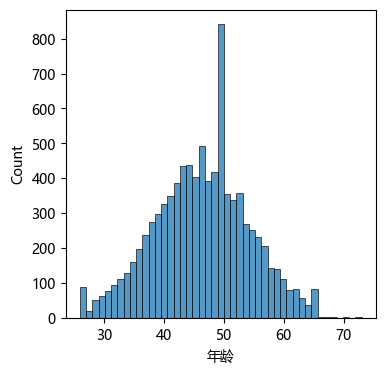

In [117]:
# 想要分析的单变量：['年龄', '性别', '是否流失']

# 对连续变量绘制直方图
plt.figure(figsize=(4, 4))
sns.histplot(x='年龄', data=data)
plt.show()

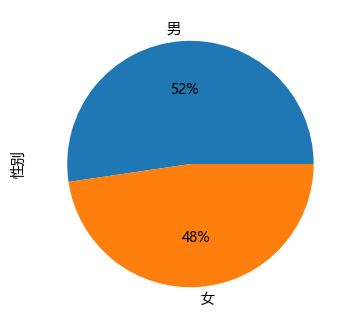

In [118]:
# 对类别变量绘制饼图
plt.figure(figsize=(4, 4))
data['性别'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.show()

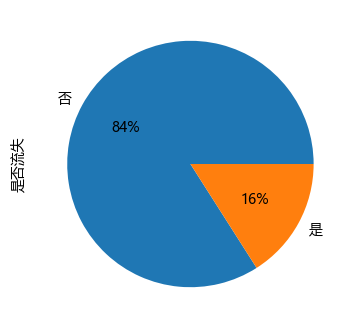

In [119]:
# 对目标类别变量绘制饼图
plt.figure(figsize=(4, 4))
data['是否流失'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.show()

### 3.2 双变量分析

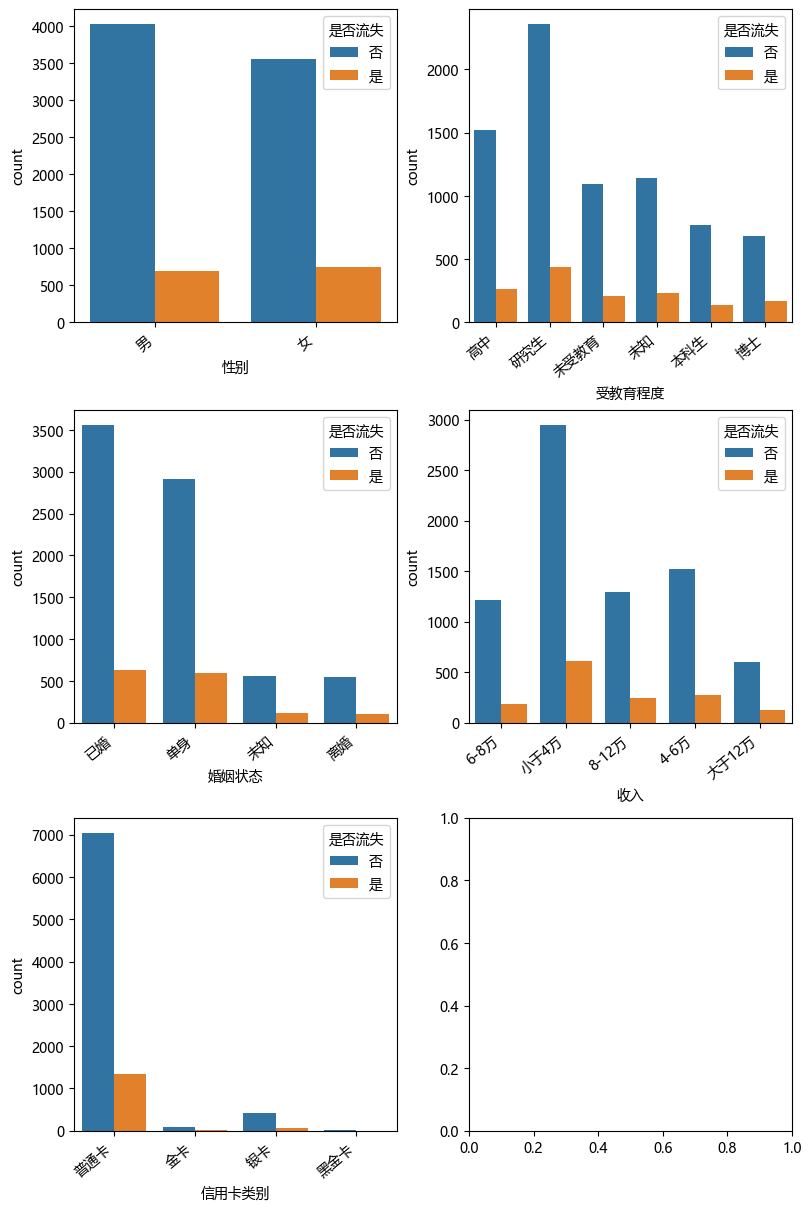

In [120]:
# 类别变量和目标变量的关系
n, m = len(category_features) // 2 + len(category_features) % 2, 2
fig, axs = plt.subplots(n, m, figsize=(m * 4, n * 4), constrained_layout=True)

for i, col in enumerate(category_features):
    sns.countplot(x = col, hue = '是否流失', data = data, ax = axs[i // 2, i % 2])
    axs[i // 2, i % 2].set_xticklabels(axs[i // 2, i % 2].get_xticklabels(), rotation=40, ha="right")
plt.show()

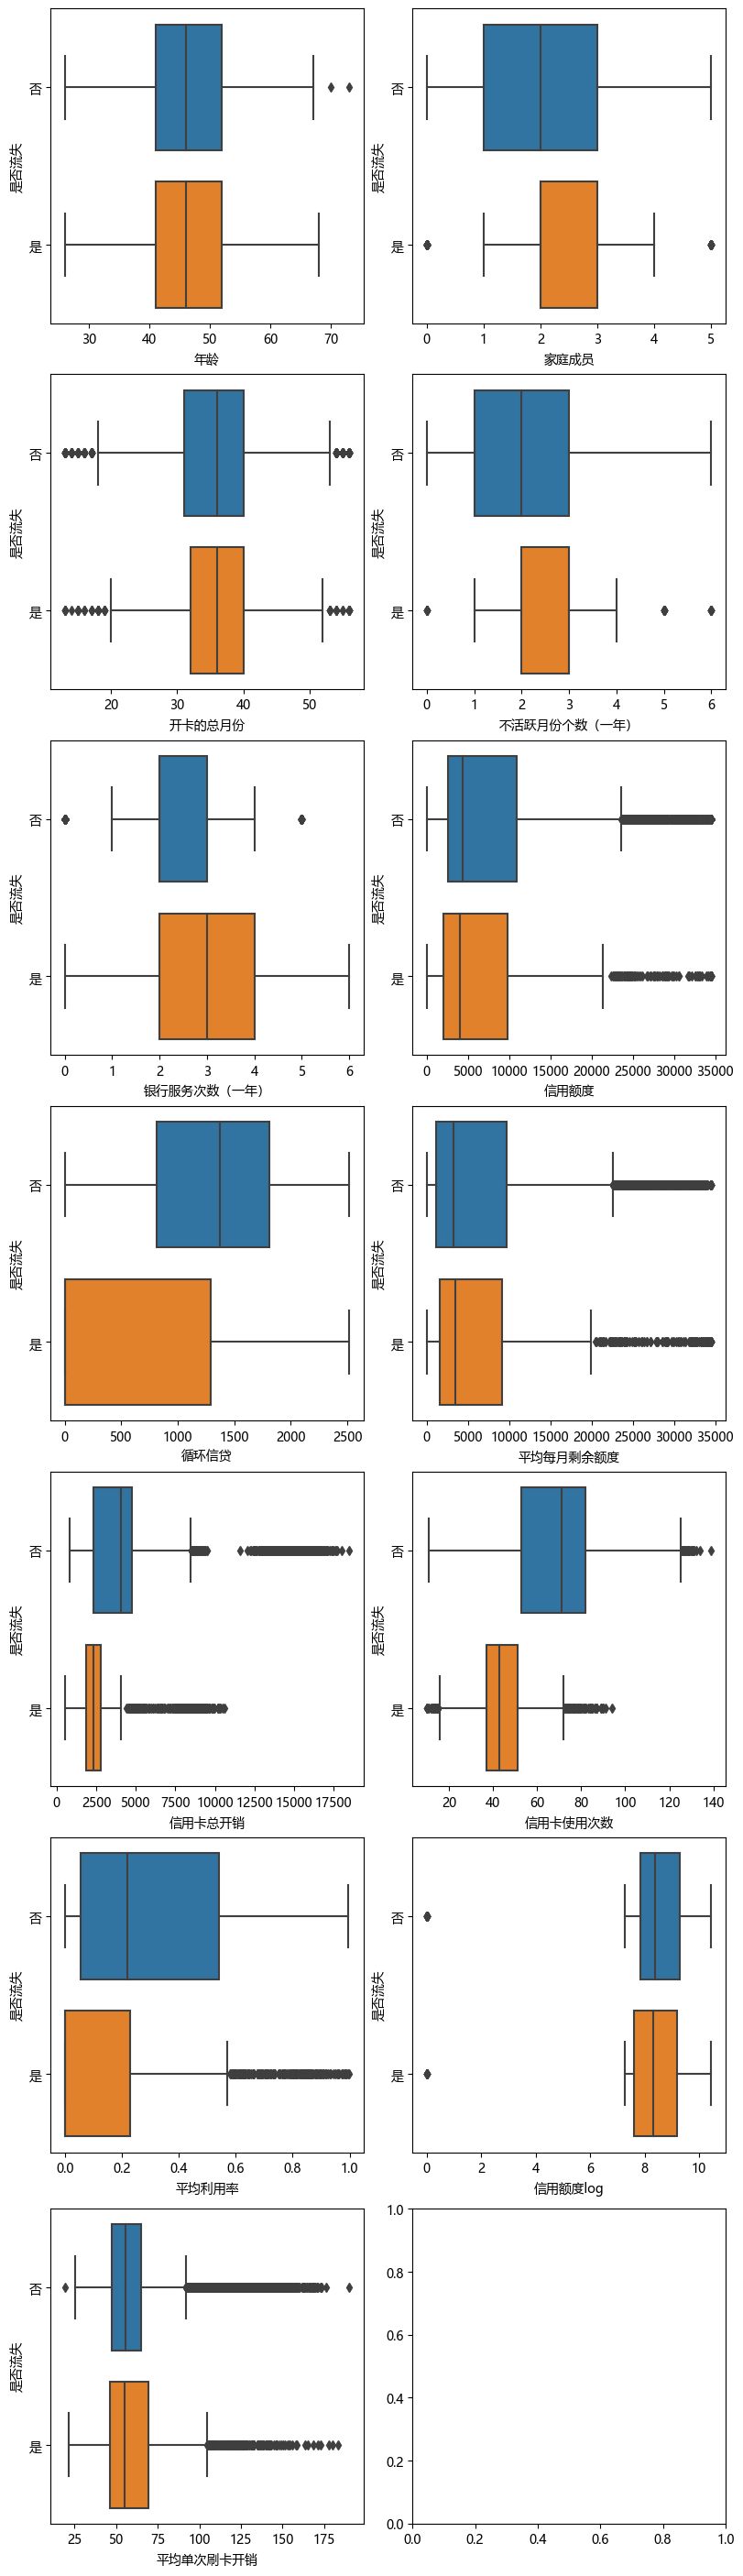

In [121]:
# 连续变量和目标变量的关系
n, m = len(continous_features) // 2 + len(continous_features) % 2, 2
fig, axs = plt.subplots(n, m, figsize=(4 * m, 4 * n), constrained_layout = True)

for i, col in enumerate(continous_features):
    sns.boxplot(x = col, y = '是否流失', data = data, ax = axs[i // 2, i % 2])
plt.show()

在箱形图中，菱形点代表该数据点是异常值（偏离下或上四分位数1.5个下到上四分位数距离）；最左侧竖线代表最小值取值；长方形最左侧边代表下四分位数取值；长方形中间竖线代表中位数取值；长方形最由侧边代表上四分位数取值；最右侧竖线代表最大值取值。

### 3.3 三变量分析
我们发现在双变量分析中，`信用卡总开销` 和 `信用卡使用次数` 都疑似对 `是否流失` 有影响。接下来我们会用`信用卡总开销`、`信用卡使用次数`、`是否流失`做三变量分析。

<AxesSubplot:xlabel='信用卡总开销', ylabel='信用卡使用次数'>

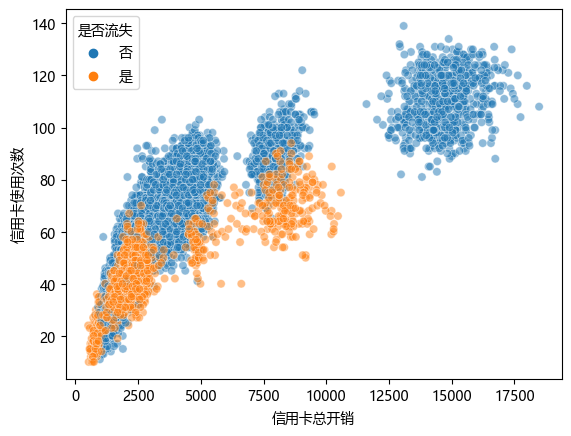

In [122]:
sns.scatterplot(x='信用卡总开销', y='信用卡使用次数', hue='是否流失', data=data, alpha=0.5)

In [123]:
# 针对上述图，我们选取以下边界值的进行分析
flag = (data['信用卡总开销'] < 3000) & (data['信用卡使用次数'] < 65)
result = data['是否流失'][flag].value_counts()

In [124]:
print(result)

否    2226
是    1121
Name: 是否流失, dtype: int64


In [125]:
print(result / result.sum())

否    0.665073
是    0.334927
Name: 是否流失, dtype: float64


In [126]:
# 结论
print(
    "边界值里面的总数据量为{}，占总数据量的{:.2f}%。 其中流失的数据量为{}，占总流失数据的{:.2f}%。".format(
        sum(flag), 
        sum(flag) / len(data) * 100, 
        result["是"], 
        result["是"] / data['是否流失'].value_counts()["是"] * 100
    )
)

边界值里面的总数据量为3347，占总数据量的37.13%。 其中流失的数据量为1121，占总流失数据的77.85%。


**结论：由此可见，在我们的边界条件下，我们只需要对37.13%的客户进行干预，就可以覆盖到77.85%的流失客户，从而有效地降低流失率。**

## 4. 决策树模型判断客户流失条件

In [127]:
from sklearn import tree
target = ['是否流失']
features = ['信用卡总开销', '信用卡使用次数'] # 用 信用卡总开销 和 信用卡使用次数 作为特征 来预测是否流失
clf = tree.DecisionTreeClassifier(max_depth = 3, random_state = 63) # 最大层数3层，设定random_state让输出结果固定
clf.fit(data[features], data[target])

DecisionTreeClassifier(max_depth=3, random_state=63)

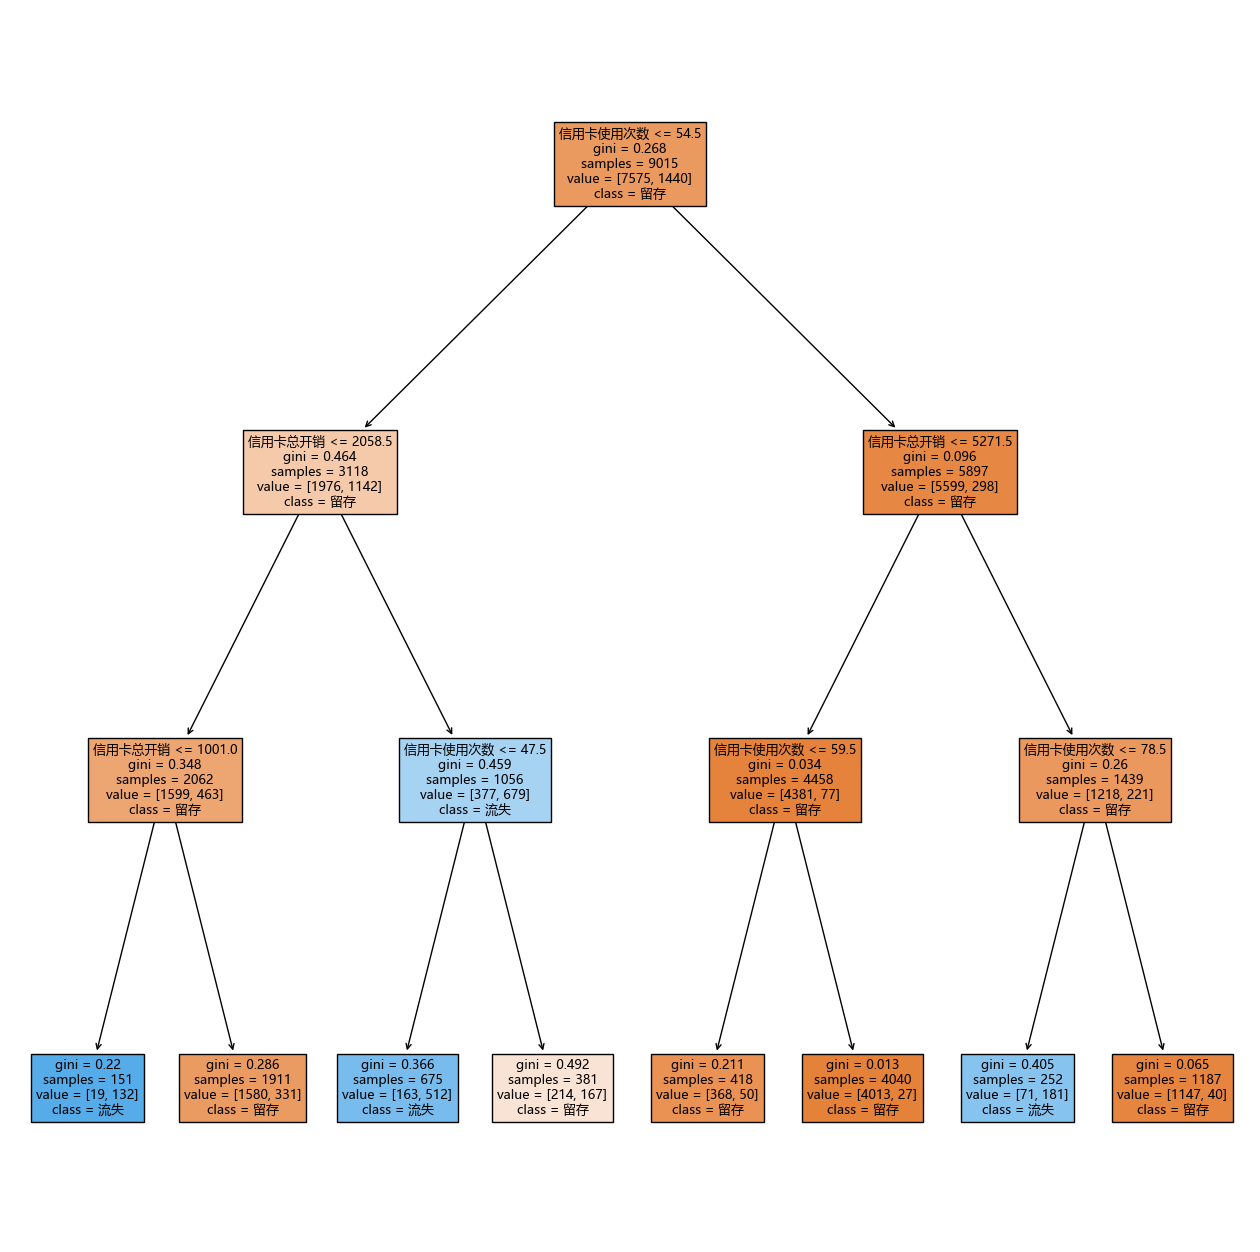

In [128]:
plt.figure(figsize=(16, 16))
tree_graph = tree.plot_tree(clf, filled=True, feature_names=features, class_names=["留存", "流失"]) 
#filled使每一节点根据当前样本内每一目标分类的数量进行上色，并输出对应的特征名称和分类名称

如何解读决策树？我们以决策树的第一个节点为例：第一行代表了当前节点的向下分类条件（信用卡使用次数<=54.5次）；第二行是该节点的gini值（0.268）；第三行代表了当前节点的样本数量（9015个）；第四行代表了当前节点每一分类的样本数（留存7575个，流失1440个）；第五行代表了当前节点的主要分类（留存）。每一节点的颜色越深代表当前节点区分度越高。

关于gini值：gini=1-Σ(当前分类的样本数/总样本数)$^2$。gini的取值范围0到0.5，0代表所有样本都在同一个分类中；0.5代表所有样本平均分配在每个分类中.

## 5. 生成流失群体分析报告

根据决策树的结果，我们可以提出不同的干预方案交给业务部门。业务部门会根据我们提供的报告，再根据业务需求选择对应的策略。以上面决策树为例，我们可以从两个方向入手提出对应的方案：高准确性或高覆盖率。

| 方案 | 占总体人数比例 | 占流失人数比例 | 解释 |
|:-----|:-------------|:--------------|:-----|
|1. 信用卡使用次数<=47.5<br>信用卡总开销<=2058.5|6.82%|35.55%|该条件下有75%的用户会流失，且该条件下的流失数量足够显著|
|2. 信用卡使用次数<=54.5<br>信用卡总开销<=2058.5|21.92%|79.3%|该条件下有占全体近80%的流失数量，且该条件下的总人数也仅有总体的约20%|

业务部门收到以上报告后，假设业务部门想先以低成本方式初步干预，那则会选择方案1，因为其准确性高达75%，较方案2相比涉及群体规模也仅为其1/3；若业务部门想尽可能多的挽留客户，那则会选择方案2，因为其覆盖了80%的流失客户，并且涉及规模也仅占整体的约1/5。<br>现实情况中，业务部门也会根据其他指标来判断对流失客户干预的优先级，如信用卡等级，开卡时长，单笔开销等。